<a href="https://colab.research.google.com/github/evan-cao-wb/Data-Analytics/blob/master/The_analytics_and_Machine_Learning_of_Lending_Club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The analytics of Lending Club**

<br> **Author**: Evan Cao

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
import os,gc
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error,r2_score,roc_auc_score,roc_curve



import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [3]:
data_path = r"/content/drive/My Drive/Github/Data/"
loan = pd.read_csv(os.path.join(data_path,"loan.csv"),low_memory=False)

In [4]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

This dataset mainly include 6 aspects of clients:
  - **Basic loan info**: loan_id, member_id, loan_amount, term, issue_date, loan_status
  - **Credit info**: sub_grad(credit grade), interest
  - **Individual info**: ownership, employer_title, employee_year, annual_income
  - **Other info**: Purpose...
  - **Geographic info**: zip_code, address_states...
  - **Public record info**: Month_since_last_decline, inquiry over past 60 days

In [5]:
# Check if there are duplicate ids/member_ids
loan.duplicated(subset=['id','member_id'] ).any() # False


# Sort data by issue date
loan.sort_values("issue_d",ascending=True,inplace=True)
loan = loan.reset_index(drop=True)

default_loan_list = ['Charged Off',"Late (31-120 days)","Late (16-30 days)",'Default',"Does not meet the credit policy. Status:Charged Off","In Grace Period" ]

loan['loan_condition'] = np.where(loan['loan_status'].isin(default_loan_list),"non-performing","performing")
loan['loan_condition'] = np.where(loan['loan_status']=="Current","on-going",loan['loan_condition'])

# Transform issue_id to datetime type and check if there is any null value
loan['issue_d'] = pd.to_datetime(loan['issue_d'])
loan['issue_d'].isnull().any() # False

loan['year'] = loan['issue_d'].dt.year

# Create region based on states
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

def get_the_region(state):
  if state in west:
      return 'West'
  elif state in south_west:
      return 'SouthWest'
  elif state in south_east:
      return 'SouthEast'
  elif state in mid_west:
      return 'MidWest'
  elif state in north_east:
      return 'NorthEast'

loan['region'] = loan['addr_state'].apply(get_the_region)



non_performing_l = loan[loan['loan_condition'] == "non-performing"]

In [6]:
print(f"There are total {len(loan.columns)} columns in dataset.")

There are total 77 columns in dataset.


## Task 1: Data Analytics

- Questions:
  - Overview about operation analysis of lending club
    - How does the number of transactions change over these years?
    - How do the loan amounts change over these years?
    - How does the number of clients change over these years?
    - How does the loan amount per person change over these years?
  - The total number of default loan every year? And how about non-performing loan ratio?
  - What kind of loan amount is most popular? And the clients how apply this kind of loan will mostly select what term to payback?
  - The range of interest?
  - Does the risk model work according to this dataset? What kind of credit will have most default loan?
  - What kind of working year is good/bad for loan application?
  - What kind of relationship is there between annual income and non-performing loan ratio?
  - What kind of purpose mostly/least cause default loan?
  - What kind of purpose will be a risk factor in the loan cases?
  - What's the most common Purpose that a client request a loan?
  - What's the distribution of Loan Amount/Interest/Loan Status?

### Q1:The analysis of Lending Club operation:
#### Q1.1 & Q1.2: How does the number of loan cases change over these years? & How do the amounts of loan cases change over these years? 

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


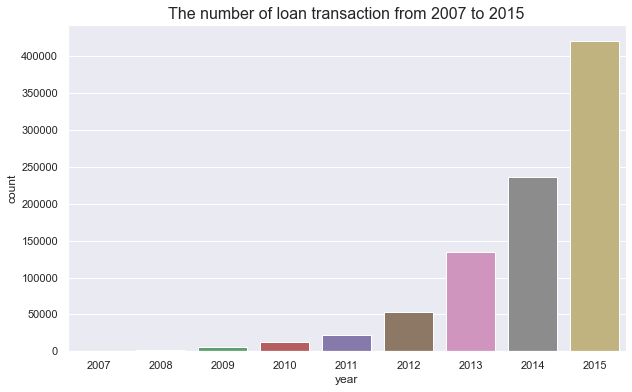

In [ ]:
# The trend of loan transaction from 2007 to 2015

plt.figure(figsize=(10,6))
sns.countplot("year",data=loan)
plt.title("The number of loan transaction from 2007 to 2015",fontsize=16)
plt.show()

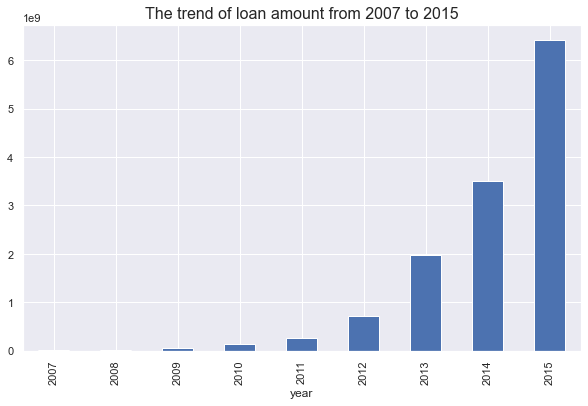

In [ ]:
# The trend of loan amount change from 2007 to 2015

plt.figure(figsize=(10,6))
loan.groupby('year')['loan_amnt'].sum().plot.bar()
plt.title("The trend of loan amount from 2007 to 2015",fontsize=16)
plt.show()

In [ ]:
# Check if there is a client who apply for loan more than twice
loan.member_id.value_counts()

58720256    1
49940977    1
31146456    1
1794524     1
62554592    1
           ..
50629066    1
10781131    1
71126929    1
45871294    1
64527060    1
Name: member_id, Length: 887379, dtype: int64

**Analysis:**
- From above two graphs, we can find the number of transactions and total loan amount are growing year by year. 
- And during these years, there is no clinets who apply for loan more then twice. 


<br> I think due to the accumulation of credit of Lending Club, the increasing number of clients bring the increment of transactions and loan amount over time.

<br> Although there is an increasing profit in Lending Club, we still wonder how default loan negatively impact the platform.


#### Q1.3: How does the number of clients change over these years?

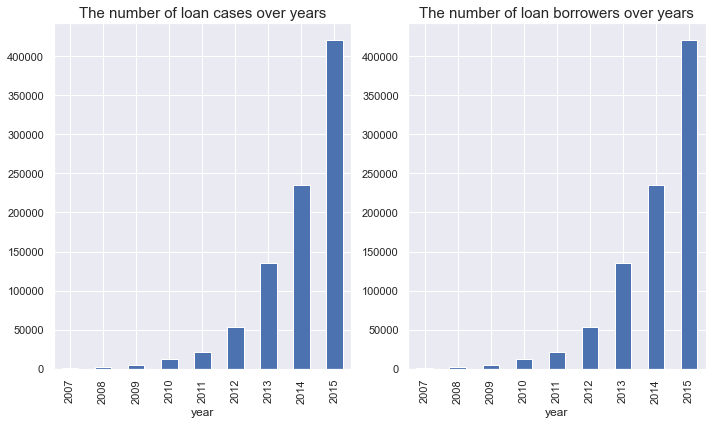

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,6))

loan.groupby('year')['id'].count().plot.bar(ax=ax[0])
ax[0].set_title("The number of loan cases over years",fontsize=15)

loan.groupby('year')['member_id'].count().plot.bar(ax=ax[1])
ax[1].set_title("The number of loan borrowers over years",fontsize=15)

plt.tight_layout()
plt.show()

**Analysis:**
- There is a growing trend over these year. It exhibits that lending club attracted a lot of clients becuase of its good reputation. 
- We should notice that this trend was growing exponentially. This increment may lead to default loan cases.

#### Q1.4: How does the loan amount per person change over these years?

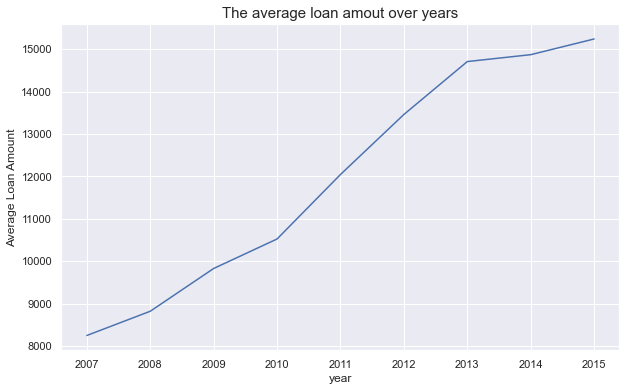

In [ ]:
plt.figure(figsize=(10,6))

loan.groupby("year")['loan_amnt'].mean().plot.line()

plt.title("The average loan amout over years",fontsize=15)
plt.ylabel("Average Loan Amount")

plt.show()

**Analysis:**
- The trend still keep increasing, its pace become more slowly.

In this step, we have a overview on Lending club operation. To improve its profitability, we should concetrate on two things: reducing the loss, increasing the profit

#### Q1.5: The distribution of loan amount

D:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


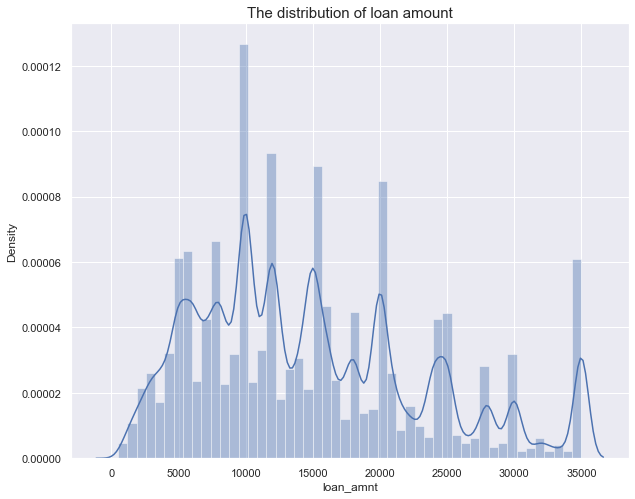

In [ ]:
plt.figure(figsize=(10,8))
sns.distplot(loan['loan_amnt'])
plt.title("The distribution of loan amount",fontsize=15)
plt.show()

In [ ]:
loan['loan_amnt'].describe()

count    887379.000000
mean      14755.264605
std        8435.455601
min         500.000000
25%        8000.000000
50%       13000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

**Analysis:**
- The average is around 15k dollars, minimum value is 500 dollars and maximum value is 35k dollars. 
- The distribution is kind of right-skwed. I guess that the lending club may focus on small loan business.

### Q2: The analysis of Default Loan (reducing the loss)

In [ ]:
# Display the kinds of default loan
loan['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [ ]:
default_loan_list = ['Charged Off',"Late (31-120 days)","Late (16-30 days)",'Default',"Does not meet the credit policy. Status:Charged Off","In Grace Period" ]


print(f"During 2007 to 2015, total number of loan is {loan.shape[0]}")
print(f"During 2007 to 2015, non-performing loan ratio is {round(non_performing_l.shape[0]/ loan.shape[0],3)}")


During 2007 to 2015, total number of loan is 887379
During 2007 to 2015, non-performing loan ratio is 0.076


#### Q2.1: What is the proportion of "on-going", "performing" and "non-performing" loan?

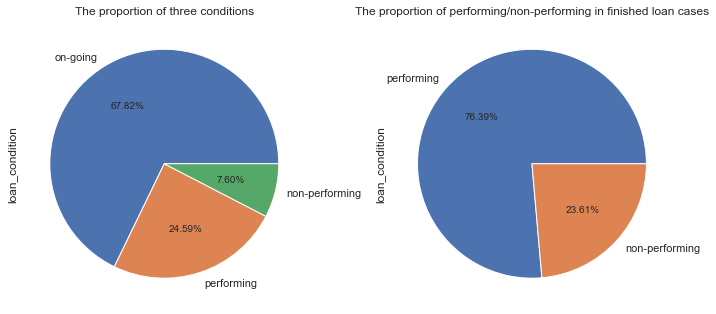

In [ ]:
fig,ax =plt.subplots(1,2,figsize=(10,8))


loan['loan_condition'].value_counts().plot.pie(autopct="%0.2f%%",ax=ax[0])
ax[0].set_title("The proportion of three conditions")

loan[loan['loan_condition']!="on-going" ]['loan_condition'].value_counts().plot.pie(autopct="%0.2f%%",ax=ax[1])
ax[1].set_title("The proportion of performing/non-performing in finished loan cases")
plt.tight_layout()
plt.show()

**Analysis:**
- In the first graph, non-performing loan ratio is 7.82%. This ratio is not so good because most commercial banks are trying to narrow this ratio to 1%-2%. And we have to take on-going loan into consideration. It is likely that default loans will appear in these on-going cases. So, this ratio is likely to be higher in the future.

- In the second graph, we can clearly find that non-performing loans nearly reach 1/4 proportion. It will cost lots of loss. We are going to explore some insights behind this phenomenon.


#### Q 2.2: The trend of three loans by years

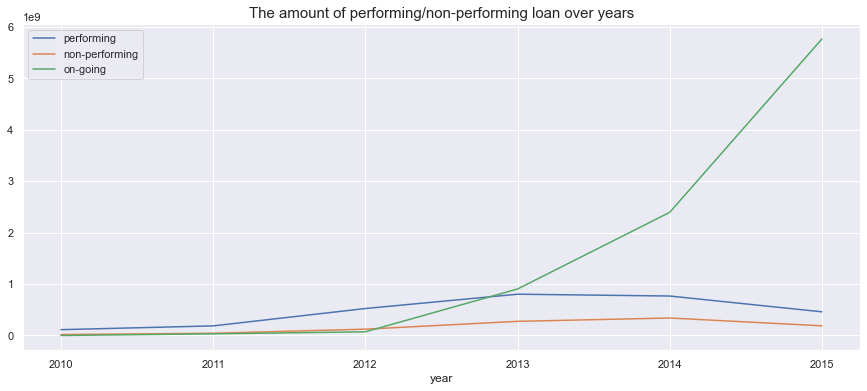

In [ ]:
tmp_df = loan[loan['loan_condition']=="performing"].groupby(["year"])['loan_amnt'].sum().reset_index().rename(columns={"loan_amnt":"performing"}).\
merge( 
loan[loan['loan_condition']=="non-performing"].groupby(["year"])['loan_amnt'].sum().reset_index().rename(columns={"loan_amnt":"non-performing"}), 
    on="year"
).merge(
loan[loan['loan_condition']=="on-going"].groupby(["year"])['loan_amnt'].sum().reset_index().rename(columns={"loan_amnt":"on-going"}), 
    on="year"
).set_index("year").plot(figsize=(15,6))
plt.title("The amount of performing/non-performing loan over years", fontsize=15)


plt.show()

**Analysis:**
<br> From the line of "on-going" status, lending club rapidly expand their businesses from 2013 to 2015. During this period, the number of default loan didn't grow and even decrease after 2014. However, performing loan also show the decreasing trend.

#### Q 2.3: How do the ratio of loan and default loan change over these years?

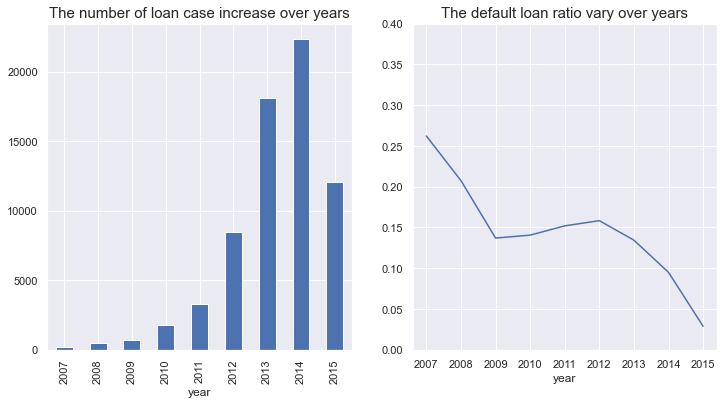

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

non_performing_l.groupby(["year"])['id'].count().plot.bar(ax=ax[0])

ax[0].set_title("The number of loan case increase over years",fontsize=15)

non_performing_ratio = non_performing_l.groupby('year')['id'].count()/loan.groupby('year')['id'].count()
non_performing_ratio.plot(kind='line',ax=ax[1])

ax[1].set_title("The default loan ratio vary over years",fontsize=15)
ax[1].set_yticks(np.arange(0,0.45,0.05))

plt.show()

**Analysis:**
<br> With increment of loan applications, the default loan ratio decrease after 2012. It displays Lending Club has a good performance in controling loan risk. 

### Q3: The analysis of Clients

#### Q3.1: What amount range is the most clients likely to select?

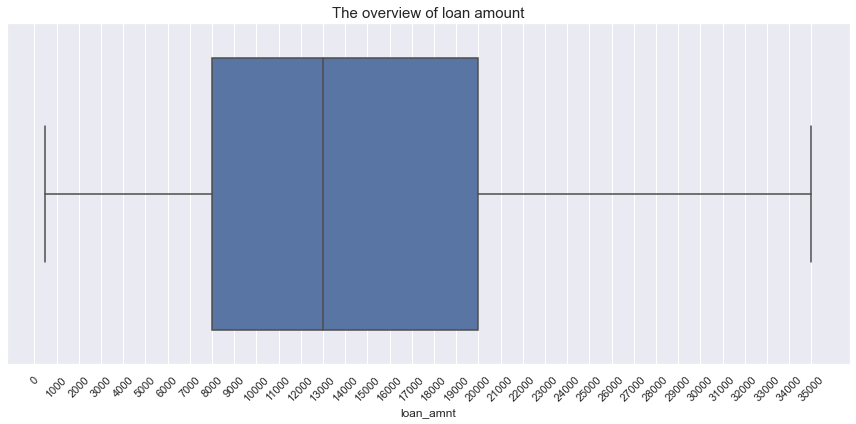

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='loan_amnt',data=loan)

plt.title("The overview of loan amount", fontsize=15)
plt.xticks(np.arange(0,loan['loan_amnt'].max()+1000,1000),rotation=45)
plt.tight_layout()
plt.show()

**Analysis:**
<br> All loan applicants borrow money below 35000 dollars. And they are more likely to select amounts between 8000 to 20000.

#### Q3.2: What kind of term is the most popular?

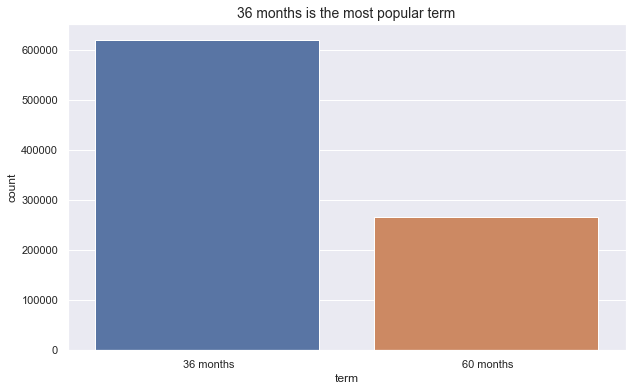

In [ ]:
plt.figure(figsize=(10,6))

sns.countplot(x = 'term',data = loan)
plt.title("36 months is the most popular term",fontsize=14)

plt.show()

**Analysis:**
<br> Loan applicants are likely to select 36 months to payback.

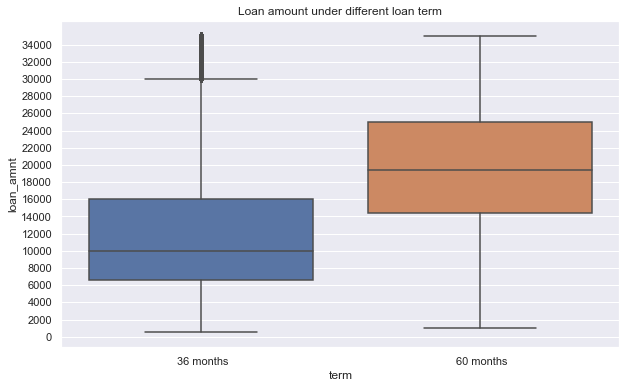

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='term',y='loan_amnt',data=loan)
plt.title("Loan amount under different loan term")
plt.yticks(np.arange(0,36000,2000))
plt.show()

**Analysis:**
People who hope to borrow large amounts of money are more likely to select a longer term to payback. The reason may be that longer terms give them fewer payback pressure per month.

#### Q3.3: The distribution of number of clients in these states. And what about their default loan ratio, annual income, loan amount and interest.

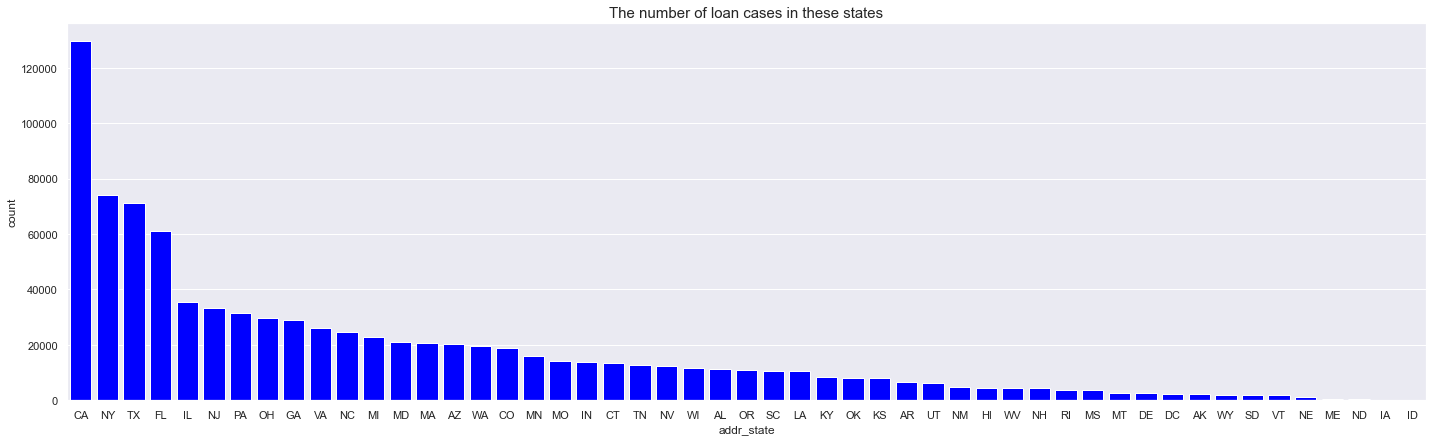

In [ ]:
plt.figure(figsize=(20,6))
g= sns.countplot(x='addr_state',data=loan,saturation=2,order=loan['addr_state'].value_counts().index,color="blue")


plt.xticks(rotation=0)
plt.tight_layout()
plt.title("The number of loan cases in these states", fontsize=15)
plt.show()

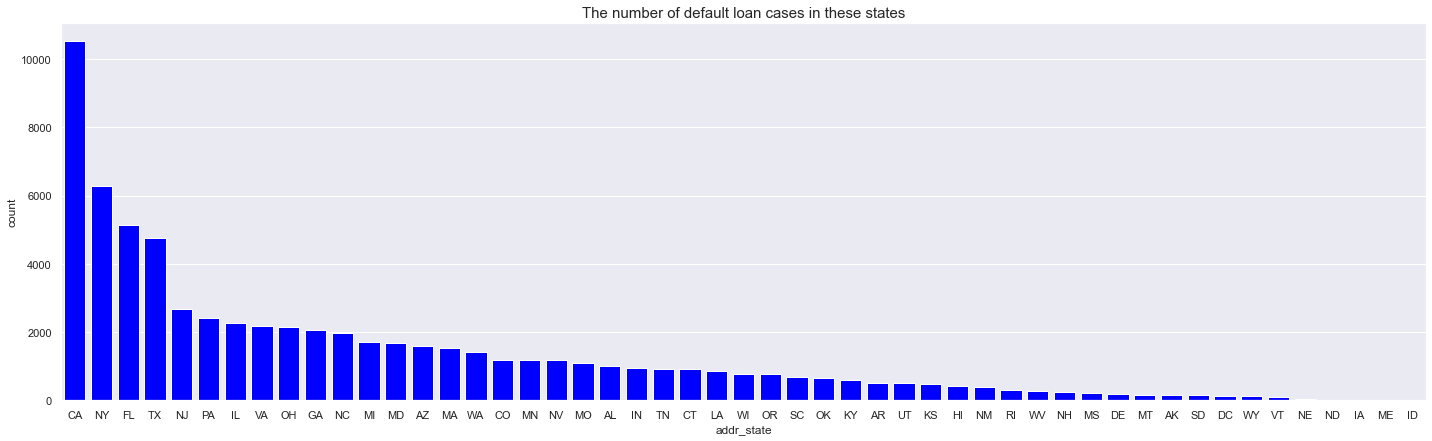

In [ ]:
plt.figure(figsize=(20,6))
g= sns.countplot(x='addr_state',data=loan[loan['loan_condition']=="non-performing"],saturation=2,order=loan[loan['loan_condition']=="non-performing"]['addr_state'].value_counts().index,color='blue')


plt.xticks(rotation=0)
plt.tight_layout()
plt.title("The number of default loan cases in these states",fontsize=15)
plt.show()

**Analysis:**
<br> From two graphs, we find there are 6 states we should pay more attention: CA, NY,FL,TX,NJ,PA due to large number of default loan cases. And we will set two thresholds to divided these states into three groups: High default, Medium defalut, and Low default. Doing so will help us to identify if this clients have default loan.

In [ ]:
# Explore loan and default loan by region
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

def get_the_region(state):
  if state in west:
      return 'West'
  elif state in south_west:
      return 'SouthWest'
  elif state in south_east:
      return 'SouthEast'
  elif state in mid_west:
      return 'MidWest'
  elif state in north_east:
      return 'NorthEast'

loan['region'] = loan['addr_state'].apply(get_the_region)
non_performing_l['region'] = non_performing_l['addr_state'].apply(get_the_region)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


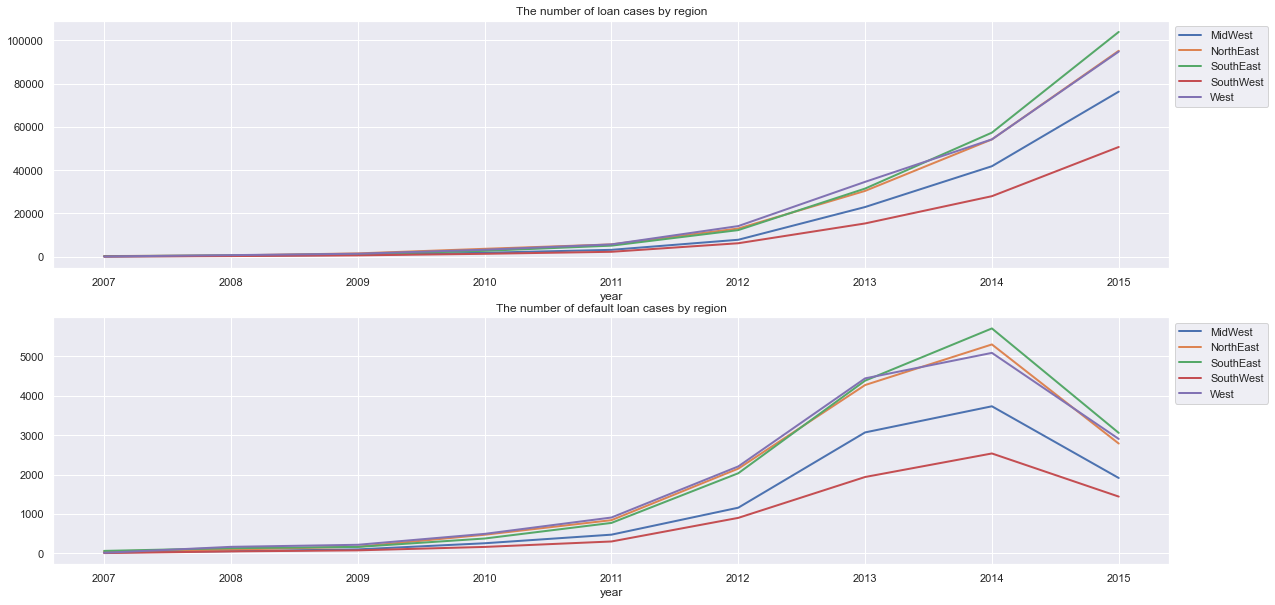

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
loan.groupby(["year",'region'])['id'].count().unstack().plot(ax = ax[0],lw=2)
ax[0].legend(bbox_to_anchor=(1,1))
ax[0].set_title("The number of loan cases by region")

non_performing_l.groupby(["year",'region'])['id'].count().unstack().plot(ax = ax[1],lw=2)
ax[1].legend(bbox_to_anchor=(1,1))
ax[1].set_title("The number of default loan cases by region")
plt.show()

**Analysis:**
There is a common trend among these states. Obviously, Lending Club upgrade its own risk-control model to curb the increment of default loan in 2014.

In [ ]:
loan['int_rate'].describe(),non_performing_l['int_rate'].describe()

(count    887379.000000
 mean         13.246740
 std           4.381867
 min           5.320000
 25%           9.990000
 50%          12.990000
 75%          16.200000
 max          28.990000
 Name: int_rate, dtype: float64,
 count    67429.000000
 mean        15.927657
 std          4.313284
 min          5.320000
 25%         12.990000
 50%         15.610000
 75%         18.750000
 max         28.990000
 Name: int_rate, dtype: float64)

D:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


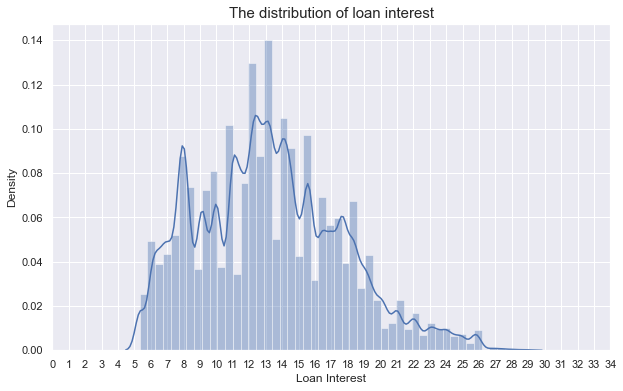

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(loan.int_rate)


plt.title("The distribution of loan interest",fontsize=15)
plt.xlabel("Loan Interest")
plt.xticks(np.arange(0,35))
plt.show()

**Analysis:**
The distribution of interest is kind of right-skewed. Most clients have the interest below 16%. The non-performing loan interest will be higher than other loan. **That means that lending club tend to lend money to those who deserve low interests.**

#### Q3.4: The relationship between initial loan purpose and default condition.

Purpose is a crucial factor to determine if this loan is non-performing because it directly reflect where this money will be used. Some good purposes will put the loan principal into safety, but other nefarious intentions will make client loss most principal so that they cannot afford monthly payback.

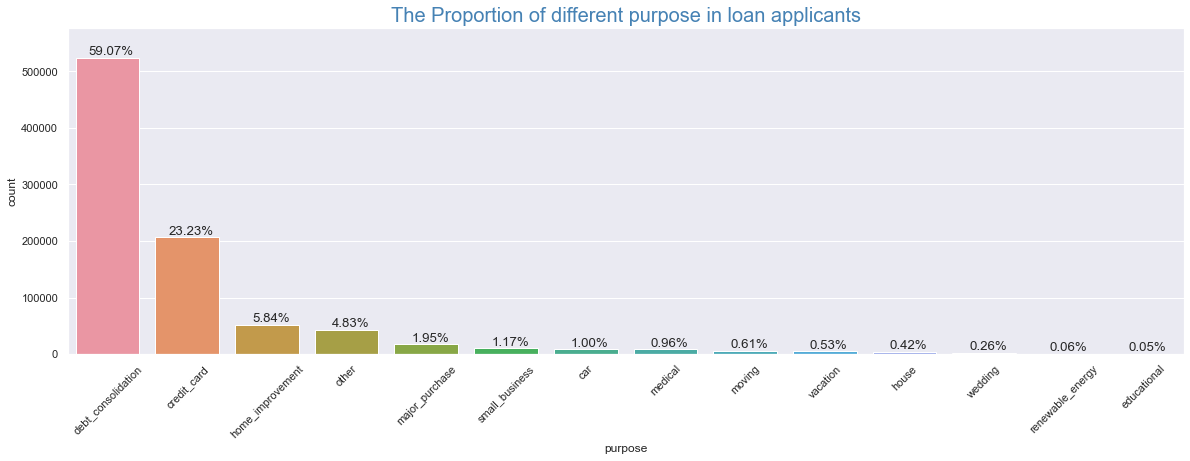

In [ ]:
plt.figure(figsize=(20,6))
g = sns.countplot(x='purpose',data=loan, orient='h',order=loan['purpose'].value_counts().index)
h = []
for p in g.patches:
    g.text(p.get_x()+p.get_width()/2+0.05, p.get_height()+5000 , f"{p.get_height()/loan.shape[0]*100:2.2f}%",ha="center",fontsize=13.3)
    h.append(p.get_height())
g.set_ylim(0, max(h)*1.1)
g.set_xticklabels(g.get_xticklabels() ,rotation=45)
plt.title("The Proportion of different purpose in loan applicants",fontsize=20,color="steelblue")
plt.show()

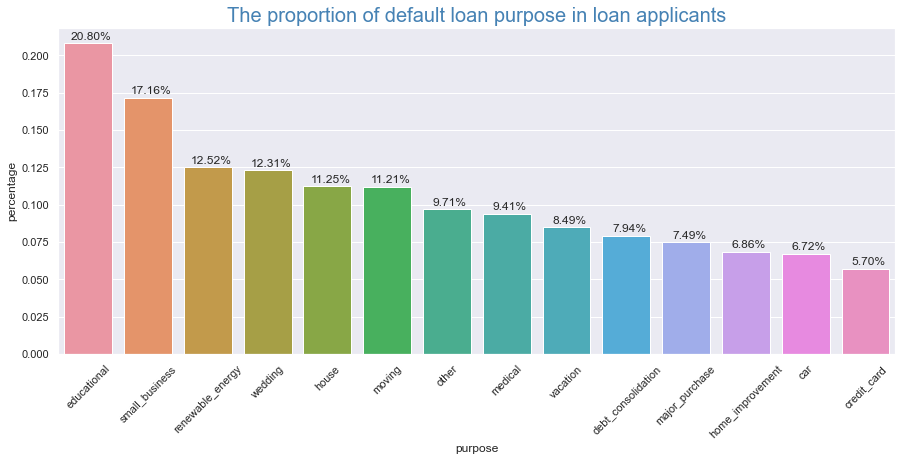

In [ ]:
purpose_df = pd.DataFrame()
p_num = []
p_list = []
for p in loan['purpose'].value_counts().index.tolist():
  p_num.append( non_performing_l[non_performing_l['purpose']==p]['id'].shape[0]/ loan[loan['purpose']==p]['id'].shape[0])
  p_list.append(p)
purpose_df['purpose'] = p_list
purpose_df['percentage'] = p_num


plt.figure(figsize=(15,6))

g = sns.barplot(x="purpose",y="percentage", data=purpose_df,order=purpose_df.sort_values(by="percentage",ascending=False)['purpose'])

for p in g.patches:
  g.text(p.get_x()+p.get_width()/2+0.05, p.get_height() +0.0025 , f"{p.get_height()*100:2.2f}%",ha="center",fontsize=12)
  

g.set_xticklabels(g.get_xticklabels() ,rotation=45)
plt.title("The proportion of default loan purpose in loan applicants",fontsize=20,color="steelblue")
plt.show()



**Education, small business and renewable energy** are top three loan purposes in default loan applications. It is not surprised for us because these purpose are mostly towards young, low income/unstable income groups. So, purpose is a significant factor to decide loan approval/reject and loan interest.

#### Q3.5: How home ownship does affect the approval of loan applications?

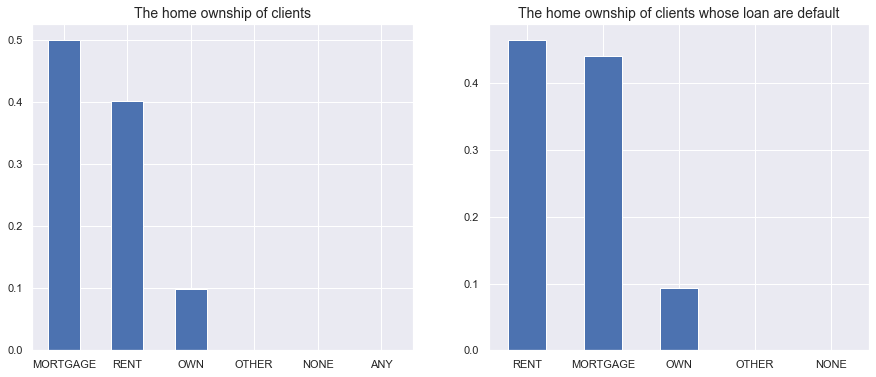

In [ ]:
fig,ax = plt.subplots(1,2)

loan['home_ownership'].value_counts(normalize=True).plot.bar(figsize=(15,6),ax=ax[0])
ax[0].set_xticklabels(labels=loan['home_ownership'].value_counts().index  ,rotation=0)
ax[0].set_title("The home ownship of clients",fontsize=14)


non_performing_l['home_ownership'].value_counts(normalize=True).plot.bar(figsize=(15,6),ax=ax[1])
ax[1].set_xticklabels(labels=non_performing_l['home_ownership'].value_counts().index ,rotation=0)
ax[1].set_title("The home ownship of clients whose loan are default",fontsize=14)

plt.show()

Rent and mortage have far higher risk than others. The reason may be they can not borrow money from bank because they don't have house or already mortage house to bank. So, they submit loan application to Lending Club so as to sovle their financial problems.

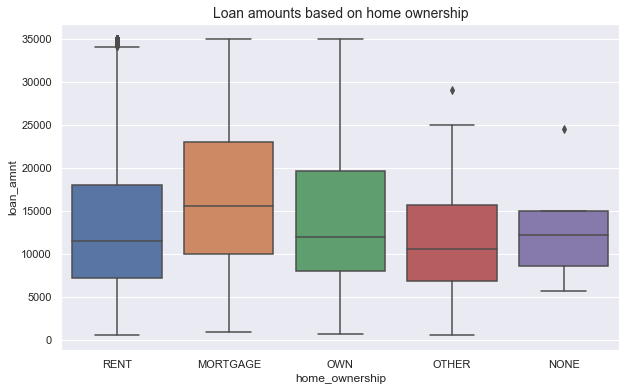

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(y="loan_amnt",x="home_ownership",data=non_performing_l,order=non_performing_l['home_ownership'].value_counts().index)

plt.title("Loan amounts based on home ownership",fontsize=14)
plt.show()

The loan amounts for mortgage and own purpose are higher than others.

#### Q3.6: How income will affect the loan status?

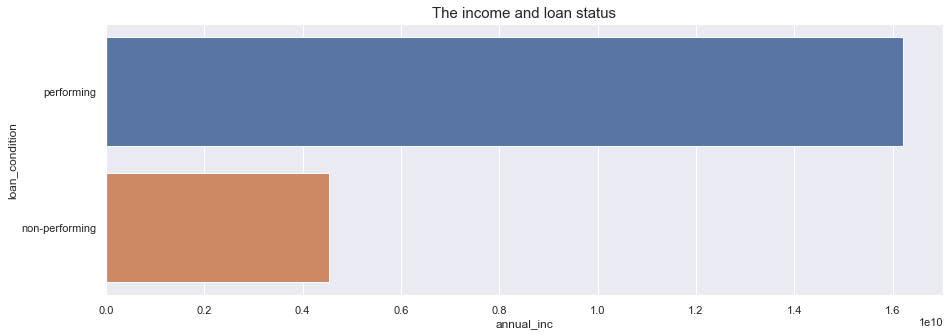

In [ ]:
tmp_df = loan[loan['loan_condition']!="on-going"].groupby("loan_condition")['annual_inc'].sum().reset_index().sort_values(by="annual_inc",ascending=False)
plt.figure(figsize=(15,5))
sns.barplot(data=tmp_df,x=tmp_df['annual_inc'],y=tmp_df['loan_condition'])
plt.title("The income and loan status", fontsize=15)
plt.show()

**Analysis:**
Obviously, the applicants of non-performing have the lowest annual income.

#### Q3.7: What kind of working years does Lending Club have low risk for lending money?

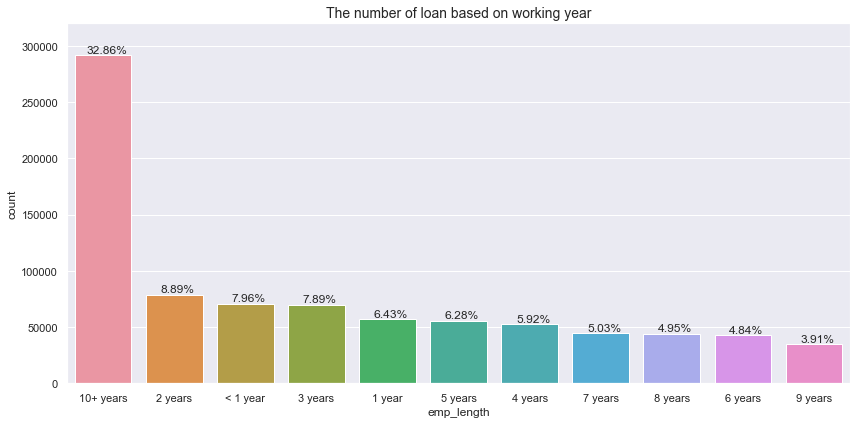

In [ ]:
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'emp_length', data=loan, order=loan['emp_length'].value_counts().index)
for p in g.patches:
    g.text(p.get_x()+p.get_width()/2+0.05, p.get_height()+2000 , f"{p.get_height()/loan.shape[0]*100:2.2f}%",ha="center",fontsize=12)

plt.ylim(0,320000)
plt.title("The number of loan based on working year",fontsize=14)
plt.tight_layout()
plt.show()

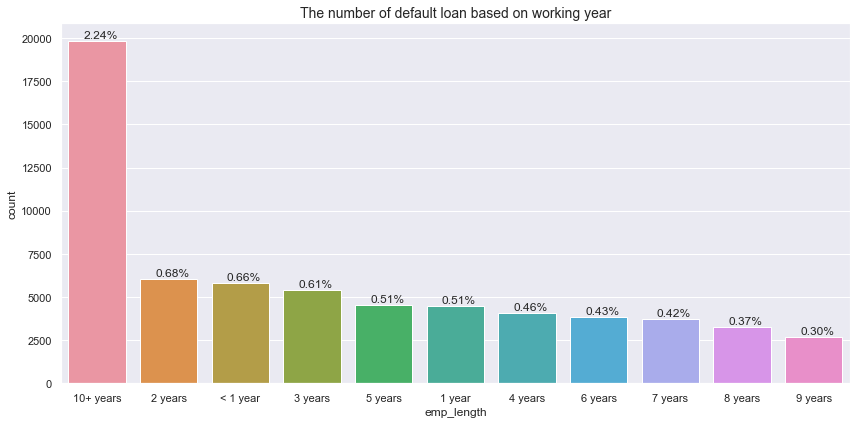

In [ ]:
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'emp_length', data=non_performing_l, order=non_performing_l['emp_length'].value_counts().index)
for p in g.patches:
    g.text(p.get_x()+p.get_width()/2+0.05, p.get_height()+150 , f"{p.get_height()/loan.shape[0]*100:2.2f}%",ha="center",fontsize=12)

plt.title("The number of default loan based on working year",fontsize=14)
plt.tight_layout()
plt.show()

Most default loans were found in 10+ years group. But we can't draw a conclusion that 10+ year is a risk factor because this group has the largest proportion in loan applicants.

### Q4: The analysis of risk controling model

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


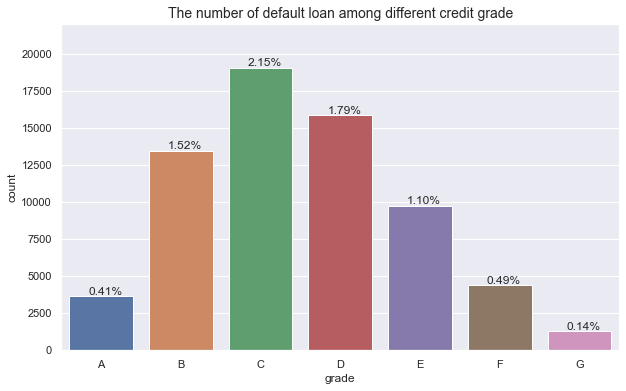

In [ ]:
non_performing_l.sort_values(by="grade",inplace=True)

plt.figure(figsize=(10,6))
g = sns.countplot("grade",data=non_performing_l)
for p in g.patches:
  g.text(p.get_x()+p.get_width()/2+0.05, p.get_height()+100 , f"{p.get_height()/loan.shape[0]*100:2.2f}%",ha="center",fontsize=12)

g.set_ylim(0, 22000)
g.set_xticklabels(g.get_xticklabels() ,rotation=0)


plt.title("The number of default loan among different credit grade",fontsize=14)
plt.show()

**Analysis:**
- It is very interesting that the number of default loan don't have positive correlationship with grades. "G" have the least number of default loan. It is possible that risk model of Lending Club reject most "G" grade clients. That's why default loan ratio begin to decrease after 2012.
- It is reasonale that "A" has the low default loan ratio. However, it is uncommon that "C" and "D" have so many clients who cannot afford loan. So, that's why Lending Club need to improve the current credit model so as to lower default loan ratio.



## Task 2: Feature Engineering

After checking Lending Club data dictionary, the following features were selected for prediction model.
- **loan_amnt**: loan amount($)
- **term**: The number of payments on the loan. Values are in months and can be either 36 or 60.
- **int_rate**: Interest Rate on the loan
- **installment**: The monthly payment owed by the borrower if the loan originates.
- **grade**: Lending Club assigned loan grade
- **emp_length**: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
- **home_ownership**: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
- **annual_inc** : The self-reported annual income provided by the borrower during registration.
- **is_inc_v**: Indicates if income was verified by LC, not verified, or if the income source was verified
- **loan_status**: Current status of the loan
- **purpose**: A category provided by the borrower for the loan request. 
- **addr_state**: The state provided by the borrower in the loan application
- **dti**: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- **delinq_2yrs**: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- **inq_last_6mths**: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
- **chargeoff_within_12_mths**: Number of charge-offs within 12 months
- **acc_now_delinq**: The number of accounts on which the borrower is now delinquent.

### 2.1 Select the the following columns to train ML model

In [7]:
loan_df = loan.drop(['id','member_id','emp_title','title','zip_code','url',"addr_state"],axis=1)

In [8]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   loan_amnt                    887379 non-null  float64       
 1   funded_amnt                  887379 non-null  float64       
 2   funded_amnt_inv              887379 non-null  float64       
 3   term                         887379 non-null  object        
 4   int_rate                     887379 non-null  float64       
 5   installment                  887379 non-null  float64       
 6   grade                        887379 non-null  object        
 7   sub_grade                    887379 non-null  object        
 8   emp_length                   842554 non-null  object        
 9   home_ownership               887379 non-null  object        
 10  annual_inc                   887375 non-null  float64       
 11  verification_status       

### 2.2 Data Clean & Transformation

In [9]:
missing_values = loan_df.isnull().sum().sort_values(ascending=False)
missing_values

dti_joint                    886870
annual_inc_joint             886868
verification_status_joint    886868
il_util                      868762
mths_since_rcnt_il           866569
                              ...  
total_pymnt                       0
out_prncp_inv                     0
out_prncp                         0
initial_list_status               0
loan_amnt                         0
Length: 70, dtype: int64

In [10]:
temp = [col for col,val in zip(missing_values.index,missing_values.values) if val>=887379 *0.7] + ['year']
loan_df.drop(columns=temp,inplace=True)

In [11]:
loan_df['issue_d']= pd.to_datetime(loan_df['issue_d']).apply(lambda x: int(x.strftime('%Y')))
loan_df['last_pymnt_d']= pd.to_datetime(loan_df['last_pymnt_d'].fillna('2016-01-01')).apply(lambda x: int(x.strftime('%m')))
loan_df['last_credit_pull_d']= pd.to_datetime(loan_df['last_credit_pull_d'].fillna("2016-01-01")).apply(lambda x: int(x.strftime('%m')))
loan_df['earliest_cr_line']= pd.to_datetime(loan_df['earliest_cr_line'].fillna('2001-08-01')).apply(lambda x: int(x.strftime('%m')))
loan_df['next_pymnt_d'] = pd.to_datetime(loan_df['next_pymnt_d'].fillna(value = '2016-02-01')).apply(lambda x:int(x.strftime("%Y")))

In [12]:
from sklearn.preprocessing import LabelEncoder
count = 0

for col in loan_df:
    if loan_df[col].dtype == 'object':
        if len(list(loan_df[col].unique())) <= 2:     
            le = LabelEncoder()
            loan_df[col] = le.fit_transform(loan_df[col])
            count += 1
            print (col)
            
print('%d columns were label encoded.' % count)

term
pymnt_plan
initial_list_status
application_type
4 columns were label encoded.


In [14]:
loan_df['mths_since_last_delinq'] = loan_df['mths_since_last_delinq'].fillna(loan_df['mths_since_last_delinq'].median())

loan_df.dropna(inplace=True)

In [29]:
year_cols = ["next_pymnt_d","issue_d"]
categorial_cols = ['grade',"sub_grade","emp_length","home_ownership","verification_status","purpose","region"]
num_cols = [i for i in loan_df.columns if (i not in year_cols+categorial_cols) & (i not in ["loan_status","loan_condition"])]

In [16]:
tmp_df = pd.get_dummies(loan_df[categorial_cols],drop_first=True)
loan_df = pd.concat([loan_df.drop(columns=categorial_cols),tmp_df],axis=1)


## Task 3:Classification Model --- Loan Status

### 3.1 Data preprocessing & features selection

In [19]:
ml_df = loan_df[loan_df['loan_condition']!="on-going"]
ml_df.shape

(209013, 116)

In [22]:
# Generate target variable: "loan_condition"
ml_df['loan_condition'] = ml_df['loan_condition'].apply(lambda x:1 if x == "non-performing" else 0)
ml_df.drop(['loan_status'],inplace=True,axis=1)

### 3.2 Split dataset into training and testing

In [32]:
categorial_cols = [i for i in ml_df.columns if i not in num_cols+year_cols]

In [38]:
from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y = train_test_split(ml_df[num_cols+categorial_cols].drop(columns="loan_condition"),ml_df['loan_condition'],test_size=0.2)

In [39]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12, ratio = 1.0)
x_train_r, y_train_r = sm.fit_sample(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### 3.3 Define the evaluation methods

In [34]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

# Helper method to print metric scores    
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                  accuracy_score(y_train, y_train_pred>threshold),
                  precision_score(y_train, y_train_pred>threshold),
                  recall_score(y_train, y_train_pred>threshold),
                  f1_score(y_train, y_train_pred>threshold)
                  ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                  accuracy_score(y_test, y_test_pred>threshold),
                  precision_score(y_test, y_test_pred>threshold),
                  recall_score(y_test, y_test_pred>threshold),
                  f1_score(y_test, y_test_pred>threshold)
                  ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                              'train':metric_values_train,
                              'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
            lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
            lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [35]:
def train_test_model(clf, X_train, y_train, X_test, y_test):
    # Fit a model by providing X and y from training set
    clf.fit(X_train, y_train)

    # Make prediction on the training data
    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]

    # Make predictions on test data
    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]

    # print model results
    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

### 3.4 Machline learning modeling

- Logistic Regression
- Decision Tree
- Random Forest
- Naive Bayes
- Gradient Boosting Tree


#### a. Logistic Regression (F1-score: 89.2%)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              train      test
metrics                      
AUC        0.991763  0.988865
Accuracy   0.954925  0.941272
Precision  0.936620  0.830121
Recall     0.975888  0.964418
f1-score   0.955851  0.892244


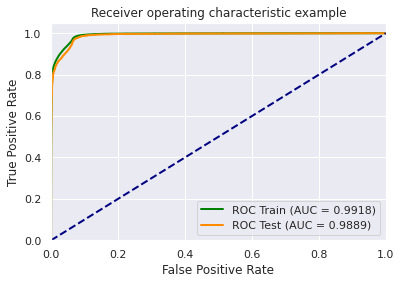

In [40]:
from sklearn.linear_model import LogisticRegression

lr_m = LogisticRegression(random_state=101)
train_test_model(lr_m,x_train_r,y_train_r,test_X,test_y)

#### b. Random Forest (F1-score:99.3%)

              train      test
metrics                      
AUC        0.999998  0.999130
Accuracy   0.998628  0.996603
Precision  1.000000  0.999424
Recall     0.997256  0.987096
f1-score   0.998626  0.993221


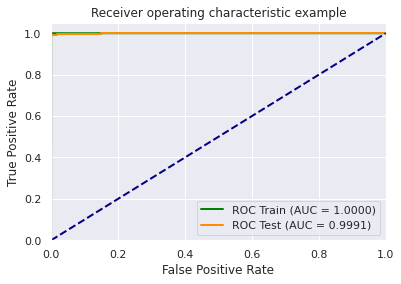

In [41]:
from sklearn.ensemble import RandomForestClassifier


rf_m = RandomForestClassifier(max_depth=16,n_jobs=4,)
train_test_model(rf_m,x_train_r,y_train_r,test_X,test_y)

#### c. Naive Bayes (F1-score:71.5%)

              train      test
metrics                      
AUC        0.969467  0.960848
Accuracy   0.836183  0.874124
Precision  0.945334  0.832514
Recall     0.713633  0.626815
f1-score   0.813304  0.715167


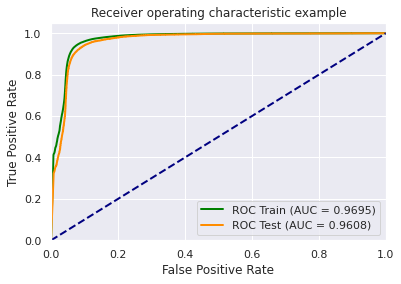

In [50]:
from sklearn.naive_bayes import GaussianNB

gnb_m = GaussianNB()
train_test_model(gnb_m,x_train_r,y_train_r,test_X,test_y)

#### d. Decision Tree (F1-score:98.83%)

              train      test
metrics                      
AUC        0.999599  0.997440
Accuracy   0.996650  0.994163
Precision  0.998269  0.992066
Recall     0.995025  0.984723
f1-score   0.996645  0.988381


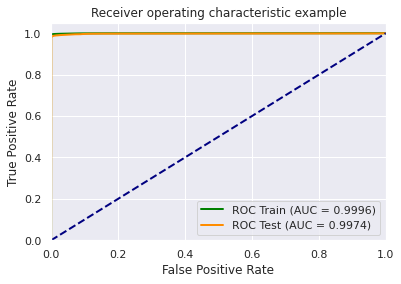

In [51]:
from sklearn.tree import DecisionTreeClassifier

dt_m = DecisionTreeClassifier(max_depth=10,)
train_test_model(dt_m, x_train_r, y_train_r,test_X,test_y)

#### e.Gradient Boosting Tree (F1-score: 99.39%)

              train      test
metrics                      
AUC        1.000000  0.999505
Accuracy   0.999844  0.996938
Precision  1.000000  0.998086
Recall     0.999687  0.989752
f1-score   0.999844  0.993902


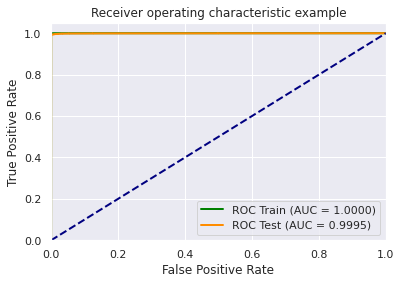

CPU times: user 20min 33s, sys: 149 ms, total: 20min 34s
Wall time: 20min 34s


In [54]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

gbdt_m = GradientBoostingClassifier(learning_rate=0.1,max_depth=10)
train_test_model(gbdt_m, x_train_r, y_train_r,test_X,test_y)

## Task 4:Regression Model --- Loan Interest

### 4.1 Data processing & Transformation

In [120]:
reg_df = loan_df[loan_df['loan_condition']!="on-going"].drop(columns="loan_condition")
reg_df.shape

(209013, 115)

In [134]:
y = reg_df['int_rate']
X = pd.concat([pd.get_dummies(reg_df['loan_status'],drop_first=True),reg_df.drop(columns=["int_rate","loan_status"])],axis=1)

### 4.2 Split dataset into training and testing

In [135]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)

### 4.3 Define the evaluation methods

In [136]:
from sklearn.metrics import mean_squared_error,r2_score
def train_test_reg_model(clf,tr_x, tr_y, ts_x, ts_y):
  clf.fit(tr_x,tr_y)
  tr_y_pred = clf.predict(tr_x)
  ts_y_pred = clf.predict(ts_x)

  print(f"Mean squared error in training set:{mean_squared_error(tr_y,tr_y_pred)}, R2 score is {r2_score(tr_y,tr_y_pred)}")

  print(f"Mean squared error in testing set:{mean_squared_error(ts_y,ts_y_pred)}, R2 score is {r2_score(ts_y,ts_y_pred)}")

### 4.4 Machine Learning Modeling

#### a. Linear Regression

In [137]:
from sklearn.linear_model import LinearRegression
lr_m = LinearRegression()
train_test_reg_model(lr_m, Xtrain,ytrain,Xtest,ytest)

Mean squared error in training set:0.2626873064677174, R2 score is 0.9868333305430699
Mean squared error in testing set:0.27874993225778644, R2 score is 0.9861210217142964


#### b. Decision Tree

In [144]:
from sklearn.tree import DecisionTreeRegressor
dt_m = DecisionTreeRegressor(max_depth=12)
train_test_reg_model(dt_m, Xtrain,ytrain,Xtest,ytest)

Mean squared error in training set:0.10663673341738182, R2 score is 0.994655049611063
Mean squared error in testing set:0.16038194555407823, R2 score is 0.9920145719077506


#### c. Random Forest

In [146]:
from sklearn.ensemble import RandomForestRegressor
rf_m = RandomForestRegressor(max_depth=12)
train_test_reg_model(rf_m, Xtrain,ytrain,Xtest,ytest)

Mean squared error in training set:0.10202803143846526, R2 score is 0.9948860514679775
Mean squared error in testing set:0.1409525725433449, R2 score is 0.9929819617253431


#### d. Gradient Boosting Tree

In [151]:
from sklearn.ensemble import GradientBoostingRegressor

gbdt_m =GradientBoostingRegressor(max_depth=9)
train_test_reg_model(gbdt_m, Xtrain,ytrain,Xtest,ytest)

Mean squared error in training set:0.06927195602227462, R2 score is 0.996527883437366
Mean squared error in testing set:0.11321130458774223, R2 score is 0.9943632013635205
